In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import sys
import csv
sns.set_style('ticks')

In [2]:
sys.path.append('..')

In [3]:
def gillespie_step(x,dt,beta,gamma, mu):
    # matrix of reactions
    rates=np.zeros((2))
    mod_matrix=np.zeros((2,3))
    mod_matrix[0,:]=([-1, +1, 0])
    mod_matrix[1,:]=([0, -1, +1])
    # first we calculate the rates of processes
    N = x[0] + x[1] + x[2]
    rates[0] = beta*x[0]*x[1]/N # infection
    rates[1] = gamma*x[1] # recovery
    for i in range(2):
        mod_i = np.random.poisson(rates[i]*dt)
        real_mod_i = min([mod_i,x[np.where(mod_matrix[i,:]<0)]])
        x = x + mod_matrix[i,:]*real_mod_i
    return x

In [4]:
def gillespie_total(x,dt,Tmax,beta,gamma,mu):
    t_curr = 0
    t = []
    res = []
    t.append(t_curr)
    res.append(x)
    while t_curr < Tmax and x[1] > 0:
        x = gillespie_step(x,dt,beta,gamma, mu)
        t_curr = t_curr + dt
        t.append(t_curr)
        res.append(x)
    return t, res

In [5]:
def gillespie_step_meta(x,dt,beta,gamma,a_meta, mu):
    # matrix of reactions
    rates = np.zeros((4))
    mod_matrix=np.zeros((4,6))
    mod_matrix[0,:] = ([-1, +1, 0, 0, 0, 0]) # infection group 1
    mod_matrix[1,:] = ([0, -1, +1, 0, 0, 0]) # recovery group 1
    mod_matrix[2,:] = ([0, 0, 0, -1, +1, 0]) # infection group 2
    mod_matrix[3,:] = ([0, 0, 0, 0, -1, +1]) # recovery group 2
    # first we calculate the rates of processes
    N = x[0] + x[1] + x[2] + x[3] + x[4] + x[5] # total population
    N_1 = x[0] + x[1] + x[2] # population of group 1
    N_2 = x[3] + x[4] + x[5] # population of group 2
    rates[0] = beta*x[0]*x[1]/N_1 + beta*a_meta*x[0]*x[4]/N_2 # infection of group 1
    rates[1] = gamma*x[1] # recovery of group 1
    rates[2] = beta*x[3]*x[4]/N_2 + beta*a_meta*x[3]*x[1]/N_1  # infection of group 2
    rates[3] = gamma*x[4] # recovery of group 2
    for i in range(4):
        mod_i = np.random.poisson(rates[i]*dt)
        real_mod_i = min([mod_i,x[np.where(mod_matrix[i,:]<0)]])
        x = x + mod_matrix[i,:]*real_mod_i
    return x

In [6]:
def gillespie_total_meta(x,dt,Tmax,beta,gamma,a_meta,mu):
    t_curr = 0
    t = []
    res = []
    t.append(t_curr)
    res.append(x)
    inf_total = x[1] + x[4]
    while t_curr < Tmax and inf_total > 0:
        x = gillespie_step_meta(x,dt,beta,gamma, a_meta, mu)
        t_curr = t_curr + dt
        t.append(t_curr)
        res.append(x)
        inf_total = x[1] + x[4]
    return t, res

# Number of propagations $N = 1$

In [5]:
N_vec = [1000,5000,10000,50000,100000,500000]
beta = 3 # 3 8
gamma = 0.2
Tmax = 200
eps = 0.03 # 0.03, 0.1, 0.01, -0.01, -0.03, 0, -0.05, 0.05 (home)
mu = 0
dt = 0.01
reps = 10000
size_list = []
time_list = []
for N in N_vec:
    print(N)
    np.random.seed(123)
    size_list_loop = []
    time_list_loop = []
    for j in range(reps):
        I0 = 1/N
        R0 = 1 - (1/(beta/gamma)) - eps - I0
        x = np.array((1 - I0 - R0,I0,R0))*N
        t, res = gillespie_total(x,dt,Tmax,beta,gamma,mu)
        res = np.array([np.array(xi) for xi in res])
        R = res[:,2]
        infected = R[-1] - R0*N 
        size_list_loop.append(infected)
        time_list_loop.append(t[-1])
        #plt.plot(t,res[:,1])
    #plt.show()
    size_list.append(size_list_loop)
    time_list.append(time_list_loop)
    name_1 = 'GTP_fsize_inf_'+str(I0)+'_'+str(eps)+'_'+str(N)+'.csv' 
    name_2 = 'GTP_ftime_inf_'+str(I0)+'_'+str(eps)+'_'+str(N)+'.csv'
    np.savetxt(name_1, size_list)
    np.savetxt(name_2, time_list)

1000
5000
10000
50000
100000
500000


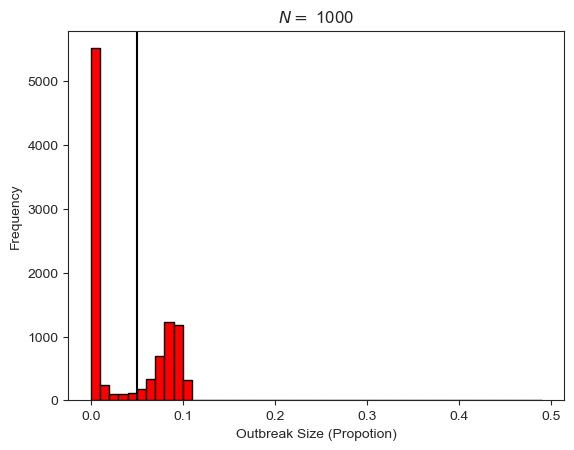

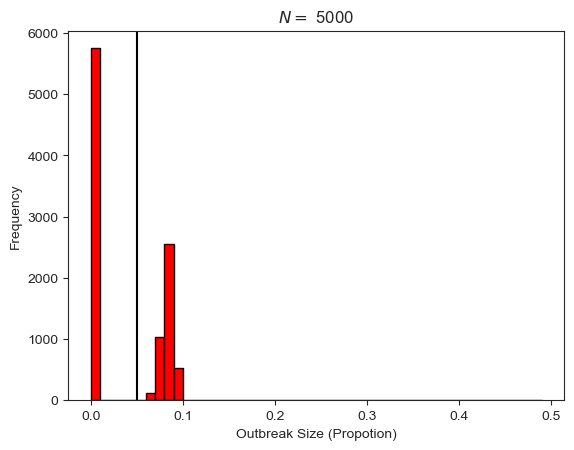

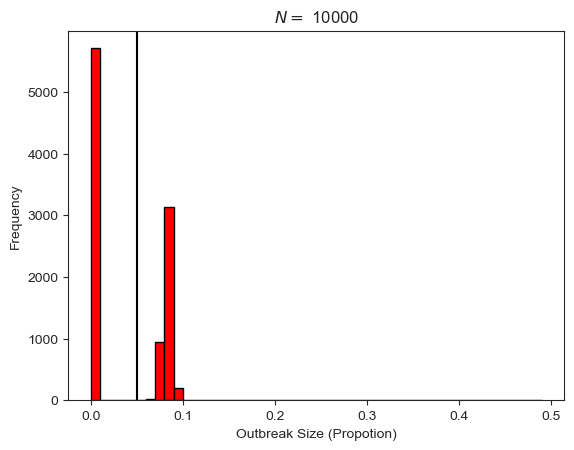

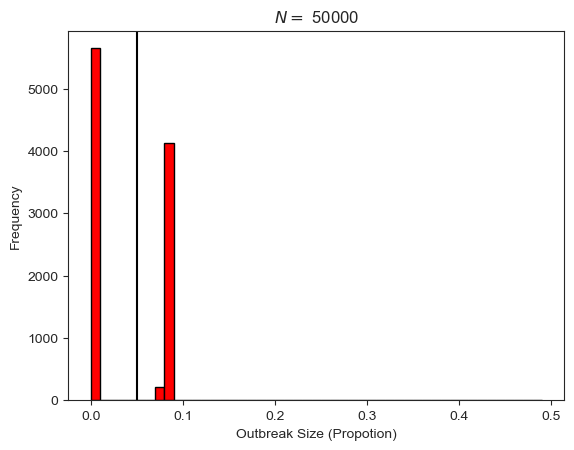

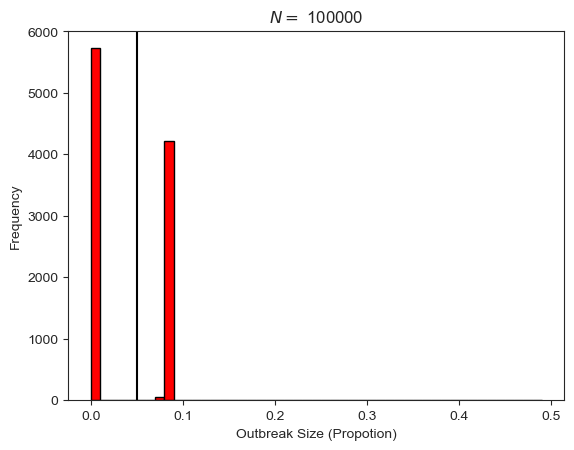

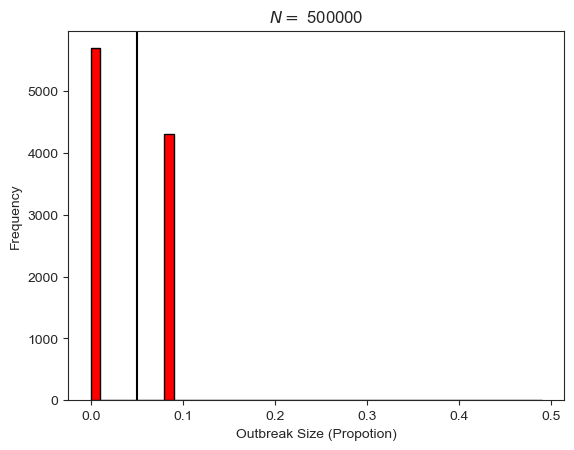

In [6]:
for i in range(len(N_vec)):
    plt.title(r'$N =$ '+str(N_vec[i]))
    bins_vec = np.arange(0,0.5,0.01)
    plt.hist(np.array(size_list[i])/N_vec[i], bins = bins_vec, edgecolor = 'black', color = 'red')
    plt.ylabel('Frequency')
    plt.xlabel('Outbreak Size (Propotion)')
    plt.axvline(eps, color = 'k')
    plt.show()

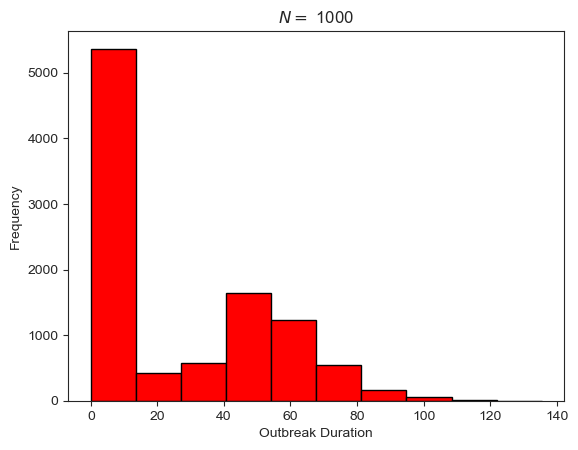

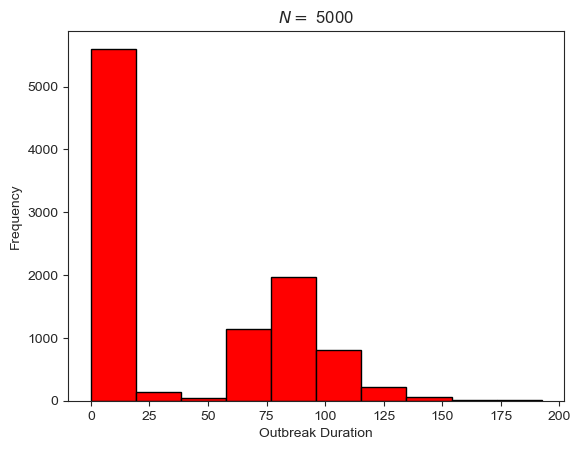

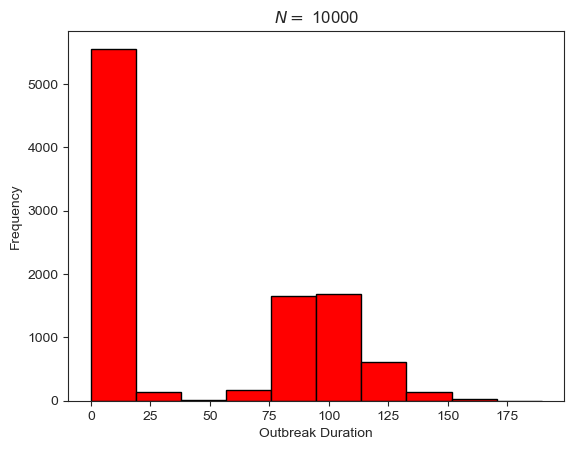

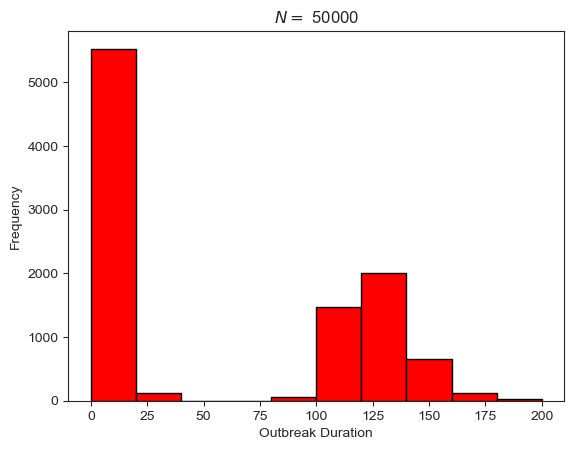

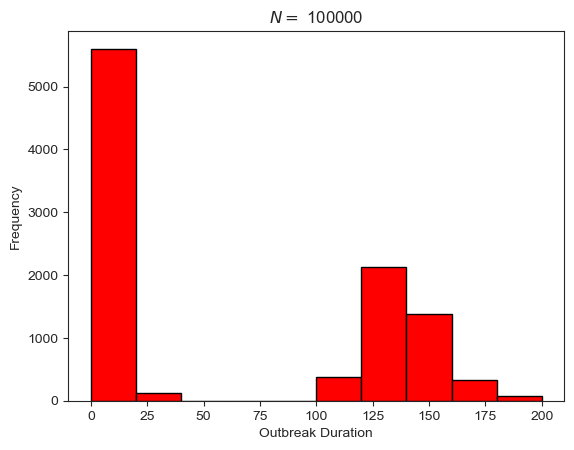

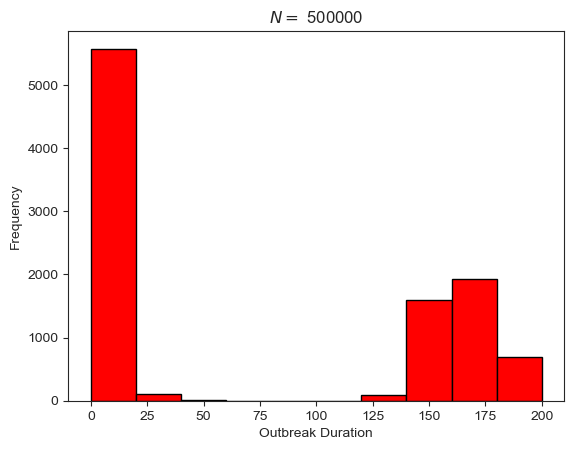

In [7]:
for i in range(len(N_vec)):
    plt.title(r'$N =$ '+str(N_vec[i]))
    plt.hist(np.array(time_list[i]), edgecolor = 'black', color = 'red')
    plt.ylabel('Frequency')
    plt.xlabel('Outbreak Duration')
    plt.show()

# Number of propagations $N = 2$

In [6]:
N_vec = [1000,5000,10000,50000,100000,500000]
beta = 3 # 3 8
gamma = 0.2
Tmax = 200
eps = -0.03 # 0.03 0.01 0.05 0.1 0 -0.01 -0.03 -0.05 (no -0.03)
mu = 0
dt = 0.01
reps = 10000
size_list = []
time_list = []
for N in N_vec:
    print(N)
    np.random.seed(123)
    size_list_loop = []
    time_list_loop = []
    for j in range(reps):
        I0 = 2/N
        R0 = 1 - (1/(beta/gamma)) - eps - I0
        x = np.array((1 - I0 - R0,I0,R0))*N
        t, res = gillespie_total(x,dt,Tmax,beta,gamma,mu)
        res = np.array([np.array(xi) for xi in res])
        R = res[:,2]
        infected = R[-1] - R0*N 
        size_list_loop.append(infected)
        time_list_loop.append(t[-1])
        #plt.plot(t,res[:,1])
    #plt.show()
    size_list.append(size_list_loop)
    time_list.append(time_list_loop)
    name_1 = 'GTP_fsize_inf_'+str(I0*N)+'_'+str(eps)+'_'+str(N)+'.csv' # modified this name for I0*N
    name_2 = 'GTP_ftime_inf_'+str(I0*N)+'_'+str(eps)+'_'+str(N)+'.csv' # modified this name fr I0*N
    np.savetxt(name_1, size_list)
    np.savetxt(name_2, time_list)

1000
5000
10000
50000
100000
500000


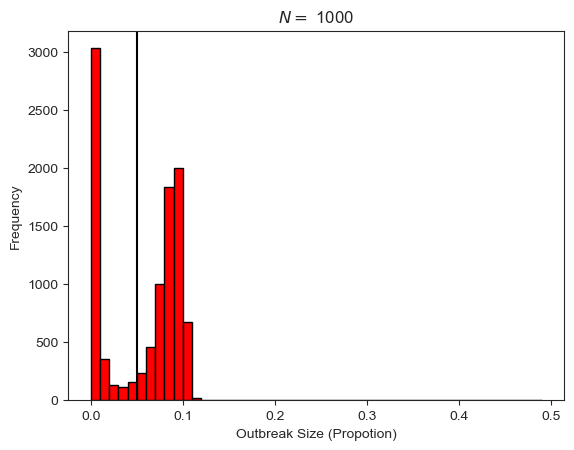

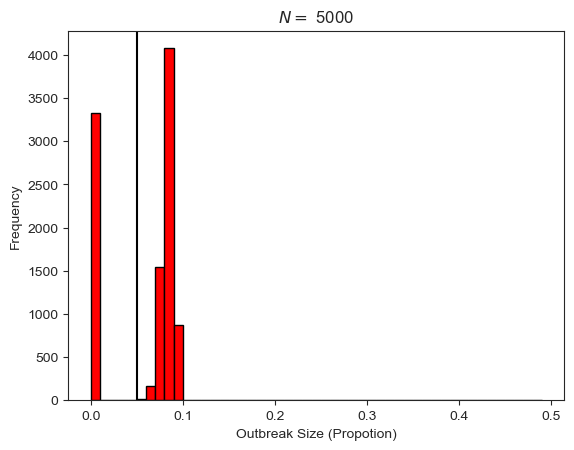

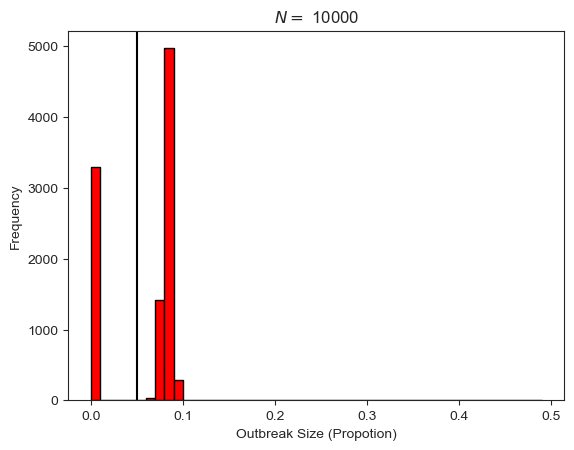

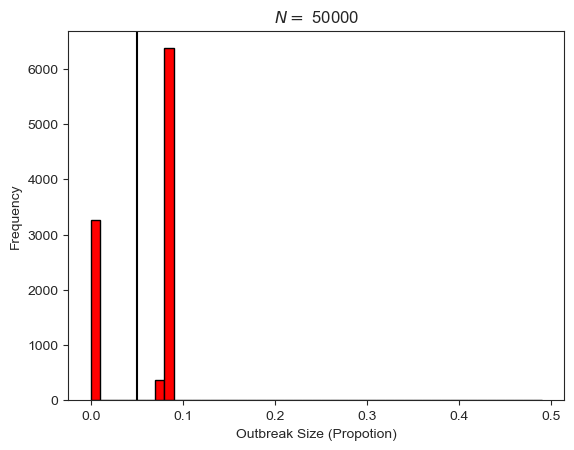

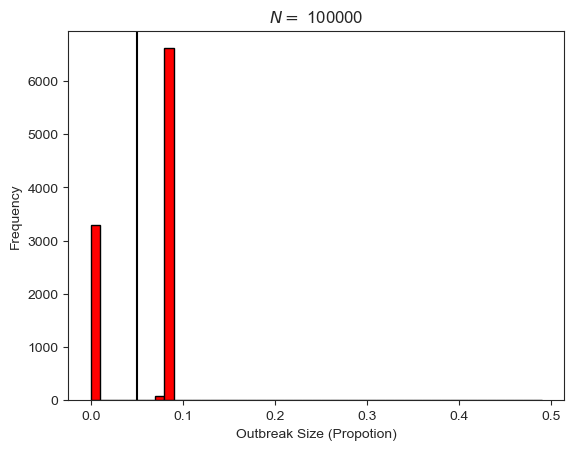

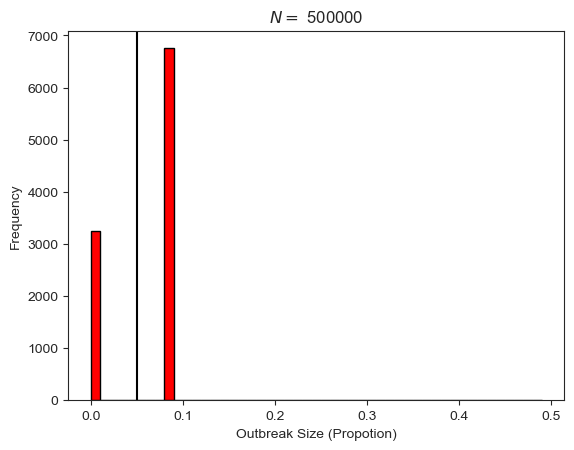

In [6]:
for i in range(len(N_vec)):
    plt.title(r'$N =$ '+str(N_vec[i]))
    bins_vec = np.arange(0,0.5,0.01)
    plt.hist(np.array(size_list[i])/N_vec[i], bins = bins_vec, edgecolor = 'black', color = 'red')
    plt.ylabel('Frequency')
    plt.xlabel('Outbreak Size (Propotion)')
    plt.axvline(eps, color = 'k')
    plt.show()

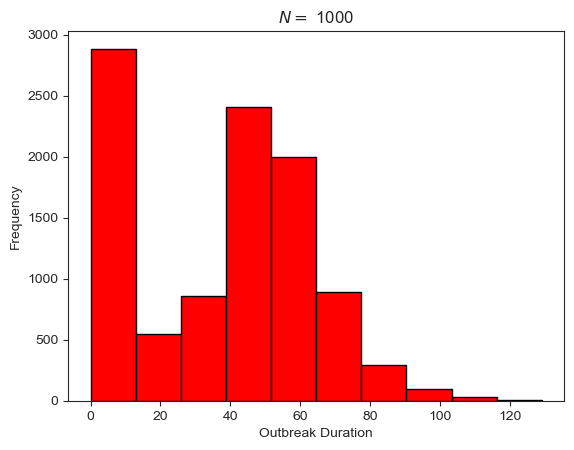

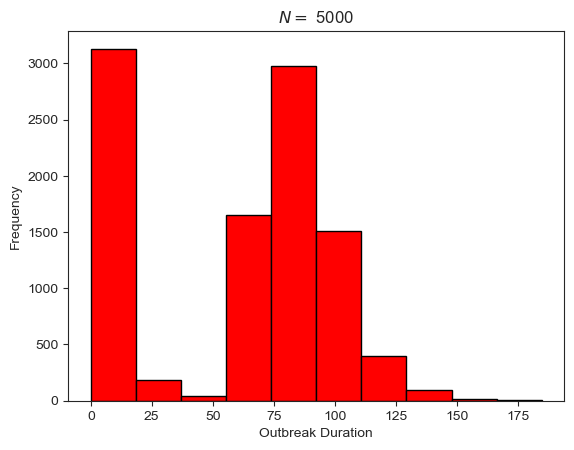

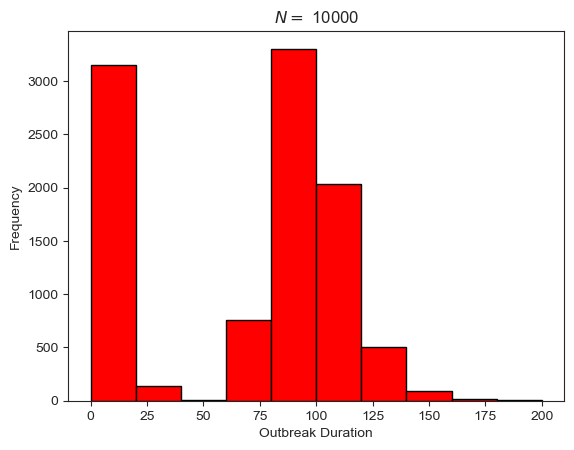

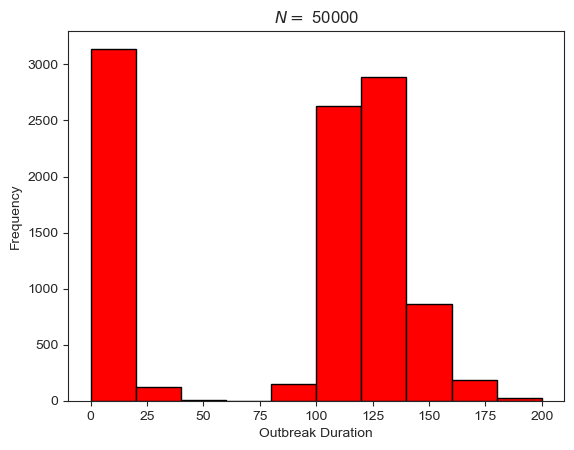

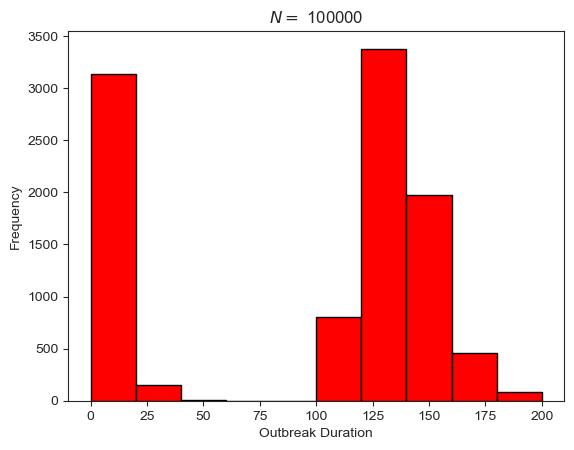

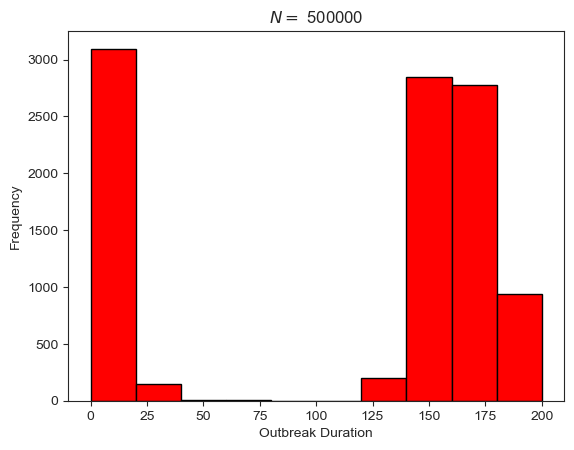

In [7]:
for i in range(len(N_vec)):
    plt.title(r'$N =$ '+str(N_vec[i]))
    plt.hist(np.array(time_list[i]), edgecolor = 'black', color = 'red')
    plt.ylabel('Frequency')
    plt.xlabel('Outbreak Duration')
    plt.show()

# Number of propagations $N = 5$

In [5]:
N_vec = [1000,5000,10000,50000,100000,500000]
beta = 3 # 3 8
gamma = 0.2
Tmax = 300 # mudei a partir do 0.1 de 5 prop
eps = 0.05 # 0.03, 0.1, 0.01 , -0.01, -0.03, -0.05, 0, 0.05
mu = 0
dt = 0.01
reps = 10000
size_list = []
time_list = []
for N in N_vec:
    print(N)
    np.random.seed(123)
    size_list_loop = []
    time_list_loop = []
    for j in range(reps):
        I0 = 5/N
        R0 = 1 - (1/(beta/gamma)) - eps - I0
        x = np.array((1 - I0 - R0,I0,R0))*N
        t, res = gillespie_total(x,dt,Tmax,beta,gamma,mu)
        res = np.array([np.array(xi) for xi in res])
        R = res[:,2]
        infected = R[-1] - R0*N 
        size_list_loop.append(infected)
        time_list_loop.append(t[-1])
        #plt.plot(t,res[:,1])
    #plt.show()
    size_list.append(size_list_loop)
    time_list.append(time_list_loop)
    name_1 = 'GTP_fsize_inf_'+str(I0*N)+'_'+str(eps)+'_'+str(N)+'.csv' 
    name_2 = 'GTP_ftime_inf_'+str(I0*N)+'_'+str(eps)+'_'+str(N)+'.csv'
    np.savetxt(name_1, size_list)
    np.savetxt(name_2, time_list)

1000
5000
10000
50000
100000
500000


In [ ]:
for i in range(len(N_vec)):
    plt.title(r'$N =$ '+str(N_vec[i]))
    bins_vec = np.arange(0,0.5,0.01)
    plt.hist(np.array(size_list[i])/N_vec[i], bins = bins_vec, edgecolor = 'black', color = 'red')
    plt.ylabel('Frequency')
    plt.xlabel('Outbreak Size (Propotion)')
    plt.axvline(eps, color = 'k')
    plt.show()

In [ ]:
for i in range(len(N_vec)):
    plt.title(r'$N =$ '+str(N_vec[i]))
    plt.hist(np.array(time_list[i]), edgecolor = 'black', color = 'red')
    plt.ylabel('Frequency')
    plt.xlabel('Outbreak Duration')
    plt.show()

# Number of propagations $N = 1$, starting with non vaccinated

In [7]:
N_vec = [100000,500000]
beta = 3 # 3 8
gamma = 0.2
a_meta = 0.5
# coverages for population 1 and 2
cov_1 = 0.95
cov_2 = 0.75
# proportion of population for population 1 and 2
prop_1 = 0.9
prop_2 = 1 - prop_1
# overall vaccine coverage
overall_cov = prop_1*cov_1 + prop_2*cov_2
# simulation specifications
Tmax = 300
mu = 0
dt = 0.01
reps = 10000
size_list_1 = []
size_list_2 = []
time_list = []
for N in N_vec:
    print(N)
    np.random.seed(123)
    size_list_loop_1 = []
    size_list_loop_2 = []
    time_list_loop = []
    for j in range(reps):
        N_01 = prop_1*N
        N_02 = N - N_01
        I0_2 = 1
        I0_1 = 0
        R0_1 = cov_1*N_01
        R0_2 = cov_2*N_02
        I0 = I0_1 + I0_2
        x = np.array((N_01 - I0_1 - R0_1, I0_1, R0_1, N_02 - I0_2 - R0_2, I0_2, R0_2))
        t, res = gillespie_total_meta(x,dt,Tmax,beta,gamma,a_meta, mu)
        res = np.array([np.array(xi) for xi in res])
        R_1 = res[:,2]
        R_2 = res[:,5]
        infected_1 = R_1[-1] - R0_1
        infected_2 = R_2[-1] - R0_2
        size_list_loop_1.append(infected_1)
        size_list_loop_2.append(infected_2)
        time_list_loop.append(t[-1])
        #plt.plot(t,res[:,1])
    #plt.show()
    size_list_1.append(size_list_loop_1)
    size_list_2.append(size_list_loop_2)
    time_list.append(time_list_loop)
    name_1 = 'GTP_fsize_inf_'+str(I0)+'_'+str(round(overall_cov,2))+'_'+str(N)+'_group1.csv' 
    name_2 = 'GTP_fsize_inf_'+str(I0)+'_'+str(overall_cov)+'_'+str(N)+'_group2.csv' 
    name_3 = 'GTP_ftime_inf_'+str(I0)+'_'+str(overall_cov)+'_'+str(N)+'.csv'
    np.savetxt(name_1, size_list_1)
    np.savetxt(name_2, size_list_2)
    np.savetxt(name_3, time_list)

100000
500000


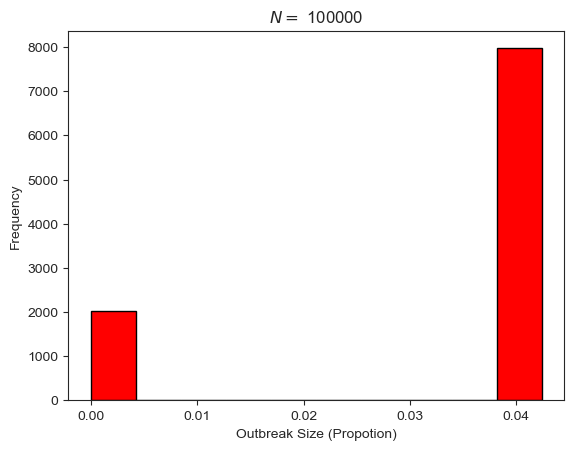

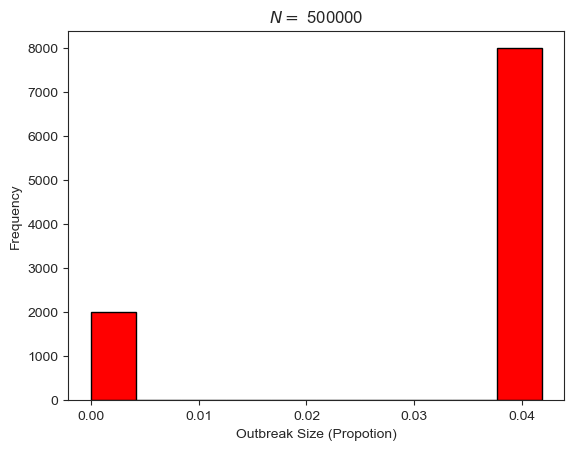

In [9]:
for i in range(len(N_vec)):
    plt.title(r'$N =$ '+str(N_vec[i]))
    plt.hist(np.array(size_list_1[i])/N_vec[i], edgecolor = 'black', color = 'red')
    plt.ylabel('Frequency')
    plt.xlabel('Outbreak Size (Propotion)')
    plt.show()

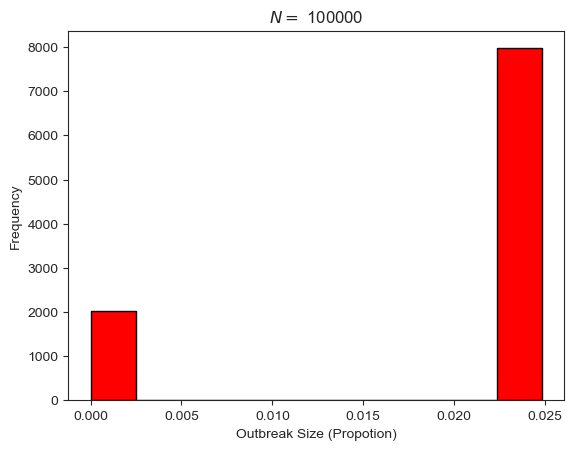

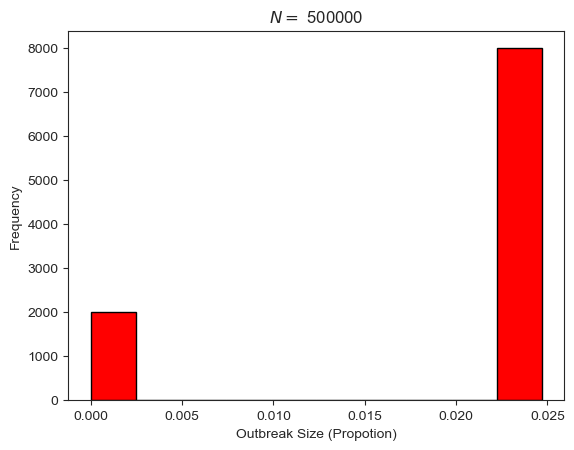

In [11]:
for i in range(len(N_vec)):
    plt.title(r'$N =$ '+str(N_vec[i]))
    plt.hist(np.array(size_list_2[i])/N_vec[i], edgecolor = 'black', color = 'red')
    plt.ylabel('Frequency')
    plt.xlabel('Outbreak Size (Propotion)')
    plt.show()

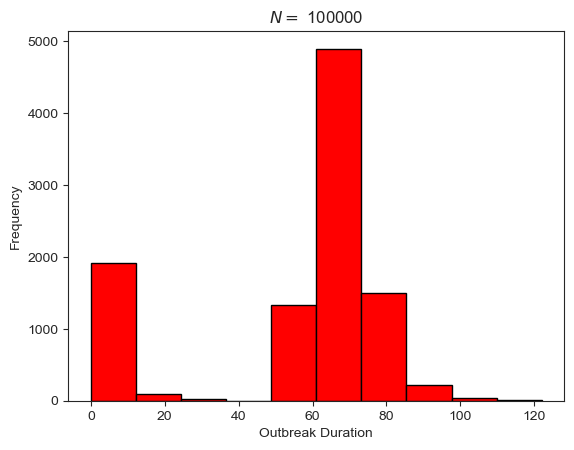

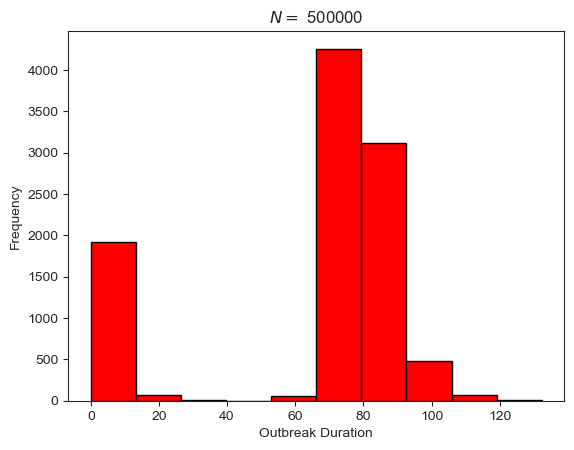

In [12]:
for i in range(len(N_vec)):
    plt.title(r'$N =$ '+str(N_vec[i]))
    plt.hist(np.array(time_list[i]), edgecolor = 'black', color = 'red')
    plt.ylabel('Frequency')
    plt.xlabel('Outbreak Duration')
    plt.show()

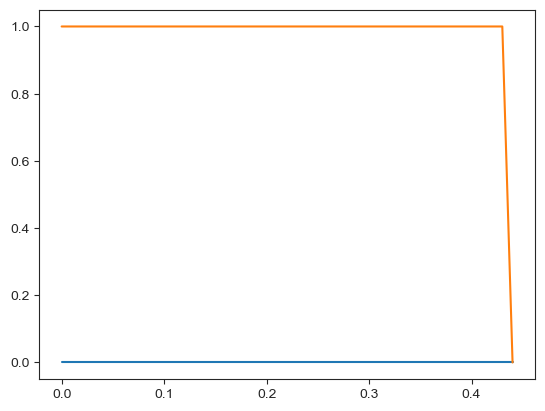

In [13]:
plt.plot(t,res[:,1])
plt.plot(t,res[:,4])

## Comparison between different initial conditions

1


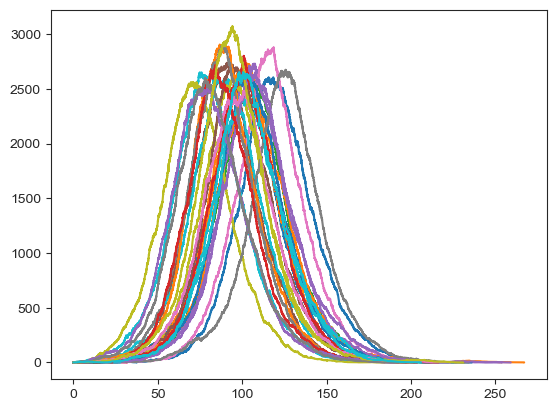

2


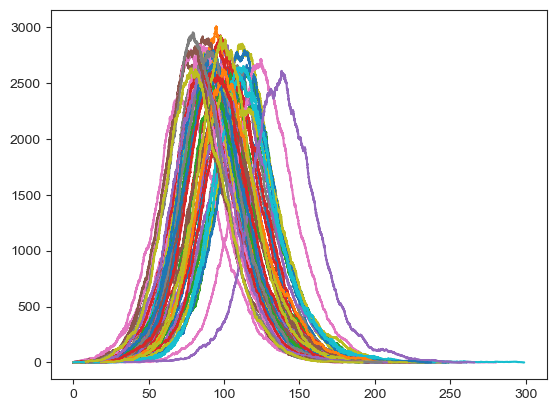

5


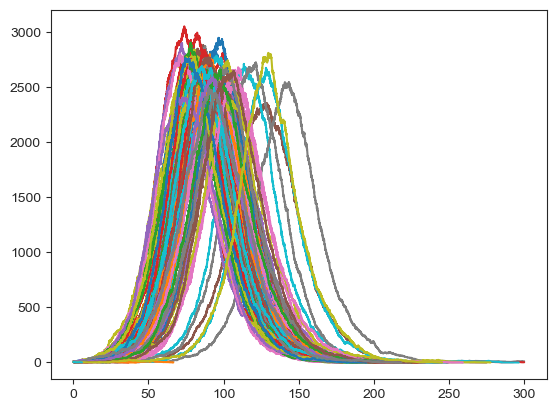

In [8]:
N = 500000
beta = 3 # 3 8
gamma = 0.2
Tmax = 300 # mudei a partir do 0.1 de 5 prop
eps = 0.03 # 0.03, 0.1, 0.01 , -0.01, -0.03, -0.05, 0, 0.05
mu = 0
dt = 0.01
reps = 100
I0_vec = [1,2,5]
for I0_val in I0_vec:
    print(I0_val)
    np.random.seed(123)
    series_list_loop = []
    for j in range(reps):
        I0 = I0_val/N
        R0 = 1 - (1/(beta/gamma)) - eps - I0
        x = np.array((1 - I0 - R0,I0,R0))*N
        t, res = gillespie_total(x,dt,Tmax,beta,gamma,mu)
        res = np.array([np.array(xi) for xi in res])
        series_list_loop.append(res[:,1].tolist())
        plt.plot(t,res[:,1])
    plt.show()
    name_1 = 'realisations_'+str(I0_val)+'_'+str(eps)+'_'+str(N)+'.csv' 
    #with open(name_1, 'w', newline='') as f:
        #writer = csv.writer(f)
        #writer.writerows(series_list_loop)

1
2
5


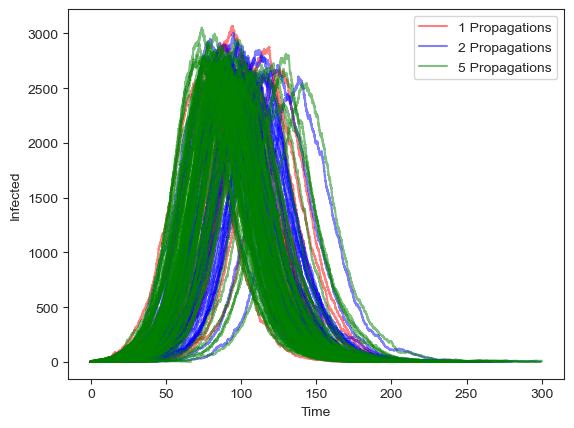

In [28]:
N = 500000
beta = 3 # 3 8
gamma = 0.2
Tmax = 300 # mudei a partir do 0.1 de 5 prop
eps = 0.03 # 0.03, 0.1, 0.01 , -0.01, -0.03, -0.05, 0, 0.05
mu = 0
dt = 0.01
reps = 100
I0_vec = [1,2,5]
colors_vec = ['red','blue','green']
label_vec = ['1 Propagations', '2 Propagations', '5 Propagations']
i = 0
for I0_val in I0_vec:
    print(I0_val)
    np.random.seed(123)
    series_list_loop = []
    for j in range(reps):
        I0 = I0_val/N
        R0 = 1 - (1/(beta/gamma)) - eps - I0
        x = np.array((1 - I0 - R0,I0,R0))*N
        t, res = gillespie_total(x,dt,Tmax,beta,gamma,mu)
        res = np.array([np.array(xi) for xi in res])
        series_list_loop.append(res[:,1].tolist())
        plt.plot(t,res[:,1], color = colors_vec[i], alpha = 0.5)
    plt.plot(t,res[:,1], color = colors_vec[i], alpha = 0.5, label = label_vec[i])
    i = i + 1
    name_1 = 'realisations_'+str(I0_val)+'_'+str(eps)+'_'+str(N)+'.csv' 
    #with open(name_1, 'w', newline='') as f:
        #writer = csv.writer(f)
        #writer.writerows(series_list_loop)
plt.xlabel('Time')
plt.ylabel('Infected')
plt.legend()
plt.show()

In [16]:
type(a)

list